In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
import re
from pelicanfs.core import PelicanFileSystem, PelicanMap,OSDFFileSystem 
# import fsspec.implementations.http as fshttp
import geopandas as gpd
from pystac_client import Client
# from odc.stac import stac_load
from rasterio.mask import mask
import rasterio
from shapely.geometry import box
from urllib.parse import urlparse

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client as dask_client
from dask.distributed import performance_report

### Use the GeoJSON file to get the Area of Interest and query the STAC catalog for items

In [3]:
# Load the GeoJSON file
geojson_path = '3100180240.geojson' 
gdf = gpd.read_file(geojson_path)

# Display the loaded GeoDataFrame
print(gdf)

                     id  SUB_AREA  COAST     PFAF_ID  DIST_MAIN    HYBAS_ID  \
0  00140000000000002983     128.1      0  3512704524      784.3  3100180240   

   DIST_SINK   NEXT_DOWN  ORDER  ENDO    MAIN_BAS   NEXT_SINK   SORT  UP_AREA  \
0      784.3  3100180230      4     0  3100009670  3100009670  66318    128.1   

                                            geometry  
0  POLYGON ((134.51667 66.87917, 134.51752 66.875...  


In [4]:
# Extract AOI geometry
aoi_geometry = gdf.geometry.iloc[0]
aoi_bounds   = aoi_geometry.bounds  # (minx, miny, maxx, maxy)

# Get AOI centroid for visualization
centroid  = aoi_geometry.centroid
long, lat = centroid.x, centroid.y

# Print the bounding box to verify
print("Bounding Box:", aoi_bounds)

Bounding Box: (134.51666686838126, 66.7708333115583, 134.9046488751149, 66.97083294070578)


In [5]:
# Connect to the Earth Search STAC API (Sentinel-2 Level-2A COGs are available here)
catalog_url = "https://earth-search.aws.element84.com/v1"
catalog     = Client.open(catalog_url)

# Define the date range as strings
start_date      = "2019-01"
end_date        = "2023-02"

# Define cloud cover threshold
cloud_cover_max = 0.05  # 5% cloud cover threshold
#cloud_cover_max = 0.20  # 20% cloud cover threshold

# Perform the search
search = catalog.search(
                 collections=["sentinel-2-l2a"],
                 bbox=aoi_bounds,
                 datetime=f"{start_date}/{end_date}",
                 #datetime="2022-06-01/2022-09-30",
                 query={"eo:cloud_cover": {"lt": cloud_cover_max * 100}}
                )

# Get all matching items
items = list(search.items())
print(f"Found {len(items)} matching items.")

Found 258 matching items.


In [6]:
# Confirm that the matching items are hosted in a aws-us-region by printing out the href links for the first n items
n=1

for i, item in enumerate(items[:n]):
    print(f"\nItem {i+1}: {item.id}")
    for asset_key, asset in item.assets.items():
        print(f"  {asset_key}: {asset.href}")


Item 1: S2B_53WMQ_20230222_0_L2A
  aot: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/AOT.tif
  blue: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B02.tif
  coastal: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B01.tif
  granule_metadata: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/granule_metadata.xml
  green: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B03.tif
  nir: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B08.tif
  nir08: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B8A.tif
  nir09: https://sentinel-cogs.s3.us-west-2.amazonaws.co

In [7]:
from shapely.geometry import mapping

# Reproject AOI to match raster CRS
from pyproj import CRS
from geopandas import GeoSeries

In [8]:
def returnOSDFPath(url):
    """
    Converts a URL to an OSDF path.

    Parameters:
    - url: URL to convert.

    Returns:
    - OSDF path.
    """
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Construct the OSDF path
    osdf_path = f"/aws-opendata/us-west-2/sentinel-cogs{parsed_url.path}"
    
    return osdf_path


### Apply various masks and calculate NDVI

In [9]:
def clp(image_src, aoi_geometry):
    """
    Clip a raster image to the Area of Interest (AOI).

    Parameters:
    - image_src: Open rasterio dataset.
    - aoi_geometry: AOI geometry as a GeoJSON-like object.

    Returns:
    - Clipped image array and updated metadata.
    """
    # out_image, out_transform = mask(image_src, [aoi_geometry], crop=True)
    out_image, out_transform = mask(image_src, aoi_geometry, crop=True)
    out_meta = image_src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    return out_image, out_meta

def maskWater(image, water_mask):
    """
    Masks out water pixels using the MODIS water mask.

    Parameters:
    - image: Raster image to mask.
    - water_mask: Water mask raster.

    Returns:
    - Water-masked image.
    """
    water = water_mask.read(1)  # Read the water mask
    mask = water < 1  # Mask water pixels (water < 1)
    image_masked = np.where(mask, image, np.nan)
    return image_masked

def maskS2snow(image, snow_prob):
    """
    Masks snow pixels using the MSK_SNWPRB (Snow Probability Mask).

    Parameters:
    - image: Raster image to mask.
    - snow_prob: Snow probability raster.

    Returns:
    - Snow-masked image.
    """
    snow = snow_prob.read(1)  # Read the snow probability mask
    mask = snow < 0.009  # Mask snow pixels (snow probability < 0.9%)
    image_masked = np.where(mask, image, np.nan)
    return image_masked

def maskWhite(image, b2, b3, b4):
    """
    Masks white pixels by converting RGB to grayscale and applying a threshold.

    Parameters:
    - image: Raster image to mask.
    - b2, b3, b4: Blue, Green, and Red bands respectively.

    Returns:
    - Grayscale-masked image.
    """
    # Convert RGB to grayscale
    grayscale = (0.3 * b4.read(1) + 0.59 * b3.read(1) + 0.11 * b2.read(1)) * 1e4
    mask = grayscale <= 2000  # Mask white pixels (grayscale > 2000)
    image_masked = np.where(mask, image, np.nan)
    return image_masked

In [10]:
%%time
# Loop through each item in the STAC query
for idx, item in enumerate(items, start=1):
    print(f"Processing dataset #{idx}")

    # Check required assets
    required_assets = ["red", "green", "blue", "scl"]
    if not all(asset in item.assets for asset in required_assets):
        print(f"Skipping dataset #{idx}: Missing required assets.")
        continue

    # Get asset URLs
    red_url = item.assets["red"].href
    green_url = item.assets["green"].href
    blue_url = item.assets["blue"].href
    scl_url = item.assets["scl"].href

    pel_red_url   = returnOSDFPath(red_url)
    pel_green_url = returnOSDFPath(green_url)
    pel_blue_url  = returnOSDFPath(blue_url)
    pel_scl_url   = returnOSDFPath(scl_url)

    pelfs = PelicanFileSystem("pelican://osg-htc.org")

    # Reproject AOI to match raster CRS
    with rasterio.open(pel_red_url,opener=pelfs) as src:
        raster_crs = CRS(src.crs)
    aoi_geometry_reprojected = GeoSeries(aoi_geometry).set_crs(gdf.crs).to_crs(raster_crs)

    # Reproject AOI to match raster CRS
    with rasterio.open(pel_red_url, opener=pelfs) as red_src, \
         rasterio.open(pel_green_url, opener=pelfs) as green_src, \
         rasterio.open(pel_blue_url, opener=pelfs) as blue_src, \
         rasterio.open(pel_scl_url, opener=pelfs) as scl_src:

    ###############################
    # # Open and clip bands
    #     with rasterio.open(red_url) as red_src, \
    #          rasterio.open(green_url) as green_src, \
    #          rasterio.open(blue_url) as blue_src, \
    #          rasterio.open(scl_url) as scl_src:
        ############################################

        aoi_geometry_reprojected = GeoSeries(aoi_geometry).set_crs(gdf.crs).to_crs(raster_crs)
        raster_bounds = box(*red_src.bounds)

        if not aoi_geometry_reprojected[0].intersects(raster_bounds):
            print(f"Warning: AOI does not intersect the bounds of {red_url}. Skipping.")
            continue

        # Clip all RGB and SCL bands to AOI
        red_clipped, red_meta = clp(red_src, aoi_geometry_reprojected)
        green_clipped, _      = clp(green_src, aoi_geometry_reprojected)
        blue_clipped, _       = clp(blue_src, aoi_geometry_reprojected)
        scl_clipped, _        = clp(scl_src, aoi_geometry_reprojected)

        # # Clip water_mask if available
        # if water_mask_available:
        #     with rasterio.open(water_mask_url) as water_mask_src:
        #         water_mask_clipped, _ = clp(water_mask_src, aoi_geometry_reprojected)

        # Apply maskS2clouds
        # red_masked = maskS2clouds(red_clipped, scl_clipped)
        # green_masked = maskS2clouds(green_clipped, scl_clipped)
        # blue_masked = maskS2clouds(blue_clipped, scl_clipped)

        # # Apply maskWater if available
        # if water_mask_available:
        #     red_masked = maskWater(red_masked, water_mask_clipped)
        #     green_masked = maskWater(green_masked, water_mask_clipped)
        #     blue_masked = maskWater(blue_masked, water_mask_clipped)

        # # Apply maskWhite
        # red_final = maskWhite(red_clipped, blue_clipped, green_clipped, red_clipped)
        # green_final = maskWhite(green_clipped, blue_clipped, green_clipped, red_clipped)
        # blue_final = maskWhite(blue_clipped, blue_clipped, green_clipped, red_clipped)

        print(f"Dataset #{idx} processed. Ready for visualization or further analysis.")

Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Processing dataset #1


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #1 processed. Ready for visualization or further analysis.
Processing dataset #2


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #2 processed. Ready for visualization or further analysis.
Processing dataset #3


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #3 processed. Ready for visualization or further analysis.
Processing dataset #4


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #4 processed. Ready for visualization or further analysis.
Processing dataset #5


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #5 processed. Ready for visualization or further analysis.
Processing dataset #6


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #6 processed. Ready for visualization or further analysis.
Processing dataset #7


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #7 processed. Ready for visualization or further analysis.
Processing dataset #8


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #8 processed. Ready for visualization or further analysis.
Processing dataset #9


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #10 processed. Ready for visualization or further analysis.
Processing dataset #11


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #11 processed. Ready for visualization or further analysis.
Processing dataset #12


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #12 processed. Ready for visualization or further analysis.
Processing dataset #13


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #13 processed. Ready for visualization or further analysis.
Processing dataset #14


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #14 processed. Ready for visualization or further analysis.
Processing dataset #15


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #15 processed. Ready for visualization or further analysis.
Processing dataset #16


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #16 processed. Ready for visualization or further analysis.
Processing dataset #17


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #17 processed. Ready for visualization or further analysis.
Processing dataset #18


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #18 processed. Ready for visualization or further analysis.
Processing dataset #19


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #19 processed. Ready for visualization or further analysis.
Processing dataset #20


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #20 processed. Ready for visualization or further analysis.
Processing dataset #21


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #21 processed. Ready for visualization or further analysis.
Processing dataset #22


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #22 processed. Ready for visualization or further analysis.
Processing dataset #23


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #23 processed. Ready for visualization or further analysis.
Processing dataset #24


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #24 processed. Ready for visualization or further analysis.
Processing dataset #25


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #25 processed. Ready for visualization or further analysis.
Processing dataset #26


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #26 processed. Ready for visualization or further analysis.
Processing dataset #27


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #27 processed. Ready for visualization or further analysis.
Processing dataset #28


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #28 processed. Ready for visualization or further analysis.
Processing dataset #29


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #29 processed. Ready for visualization or further analysis.
Processing dataset #30


No working cache found
No working cache found
No working cache found
No working cache found
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #30 processed. Ready for visualization or further analysis.
Processing dataset #31


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #31 processed. Ready for visualization or further analysis.
Processing dataset #32


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #32 processed. Ready for visualization or further analysis.
Processing dataset #33


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #33 processed. Ready for visualization or further analysis.
Processing dataset #34


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #34 processed. Ready for visualization or further analysis.
Processing dataset #35


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #35 processed. Ready for visualization or further analysis.
Processing dataset #36


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #36 processed. Ready for visualization or further analysis.
Processing dataset #37


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #37 processed. Ready for visualization or further analysis.
Processing dataset #38


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #38 processed. Ready for visualization or further analysis.
Processing dataset #39


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #39 processed. Ready for visualization or further analysis.
Processing dataset #40


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #40 processed. Ready for visualization or further analysis.
Processing dataset #41


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #41 processed. Ready for visualization or further analysis.
Processing dataset #42


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #42 processed. Ready for visualization or further analysis.
Processing dataset #43


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #43 processed. Ready for visualization or further analysis.
Processing dataset #44


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #44 processed. Ready for visualization or further analysis.
Processing dataset #45


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #45 processed. Ready for visualization or further analysis.
Processing dataset #46


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #46 processed. Ready for visualization or further analysis.
Processing dataset #47


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #47 processed. Ready for visualization or further analysis.
Processing dataset #48


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #48 processed. Ready for visualization or further analysis.
Processing dataset #49


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #49 processed. Ready for visualization or further analysis.
Processing dataset #50


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #50 processed. Ready for visualization or further analysis.
Processing dataset #51


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #51 processed. Ready for visualization or further analysis.
Processing dataset #52


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #52 processed. Ready for visualization or further analysis.
Processing dataset #53


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #53 processed. Ready for visualization or further analysis.
Processing dataset #54


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #54 processed. Ready for visualization or further analysis.
Processing dataset #55


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #55 processed. Ready for visualization or further analysis.
Processing dataset #56


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #56 processed. Ready for visualization or further analysis.
Processing dataset #57


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #57 processed. Ready for visualization or further analysis.
Processing dataset #58


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #58 processed. Ready for visualization or further analysis.
Processing dataset #59


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #59 processed. Ready for visualization or further analysis.
Processing dataset #60


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #60 processed. Ready for visualization or further analysis.
Processing dataset #61


No working cache found
No working cache found
No working cache found
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #61 processed. Ready for visualization or further analysis.
Processing dataset #62


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #62 processed. Ready for visualization or further analysis.
Processing dataset #63


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #63 processed. Ready for visualization or further analysis.
Processing dataset #64


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #64 processed. Ready for visualization or further analysis.
Processing dataset #65


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #65 processed. Ready for visualization or further analysis.
Processing dataset #66


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #66 processed. Ready for visualization or further analysis.
Processing dataset #67


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #67 processed. Ready for visualization or further analysis.
Processing dataset #68


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #68 processed. Ready for visualization or further analysis.
Processing dataset #69


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #69 processed. Ready for visualization or further analysis.
Processing dataset #70


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #70 processed. Ready for visualization or further analysis.
Processing dataset #71


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
No working cache found
No working cache found
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #71 processed. Ready for visualization or further analysis.
Processing dataset #72


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #72 processed. Ready for visualization or further analysis.
Processing dataset #73


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #73 processed. Ready for visualization or further analysis.
Processing dataset #74


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #74 processed. Ready for visualization or further analysis.
Processing dataset #75


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #76 processed. Ready for visualization or further analysis.
Processing dataset #77


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #77 processed. Ready for visualization or further analysis.
Processing dataset #78


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #78 processed. Ready for visualization or further analysis.
Processing dataset #79


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #79 processed. Ready for visualization or further analysis.
Processing dataset #80


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #80 processed. Ready for visualization or further analysis.
Processing dataset #81


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #81 processed. Ready for visualization or further analysis.
Processing dataset #82


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #82 processed. Ready for visualization or further analysis.
Processing dataset #83


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #83 processed. Ready for visualization or further analysis.
Processing dataset #84


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #84 processed. Ready for visualization or further analysis.
Processing dataset #85


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #85 processed. Ready for visualization or further analysis.
Processing dataset #86


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #86 processed. Ready for visualization or further analysis.
Processing dataset #87


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #88 processed. Ready for visualization or further analysis.
Processing dataset #89


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #90 processed. Ready for visualization or further analysis.
Processing dataset #91


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #91 processed. Ready for visualization or further analysis.
Processing dataset #92


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #92 processed. Ready for visualization or further analysis.
Processing dataset #93


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #94 processed. Ready for visualization or further analysis.
Processing dataset #95


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #95 processed. Ready for visualization or further analysis.
Processing dataset #96


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #96 processed. Ready for visualization or further analysis.
Processing dataset #97


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #97 processed. Ready for visualization or further analysis.
Processing dataset #98


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #98 processed. Ready for visualization or further analysis.
Processing dataset #99


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #99 processed. Ready for visualization or further analysis.
Processing dataset #100


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #100 processed. Ready for visualization or further analysis.
Processing dataset #101


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #101 processed. Ready for visualization or further analysis.
Processing dataset #102


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #102 processed. Ready for visualization or further analysis.
Processing dataset #103


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #103 processed. Ready for visualization or further analysis.
Processing dataset #104


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #104 processed. Ready for visualization or further analysis.
Processing dataset #105


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #105 processed. Ready for visualization or further analysis.
Processing dataset #106


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #106 processed. Ready for visualization or further analysis.
Processing dataset #107


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #107 processed. Ready for visualization or further analysis.
Processing dataset #108


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Dataset #108 processed. Ready for visualization or further analysis.
Processing dataset #109


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Discovery URL pelican://osg-htc.org/ does not match pelican://test/


RasterioIOError: /vsiriopener_07cb2229e57a48c094131364b6f6eb6a//aws-opendata/us-west-2/sentinel-cogs/sentinel-s2-l2a-cogs/53/W/MQ/2021/2/S2A_53WMQ_20210210_1_L2A/B03.tif: Resource temporarily unavailable

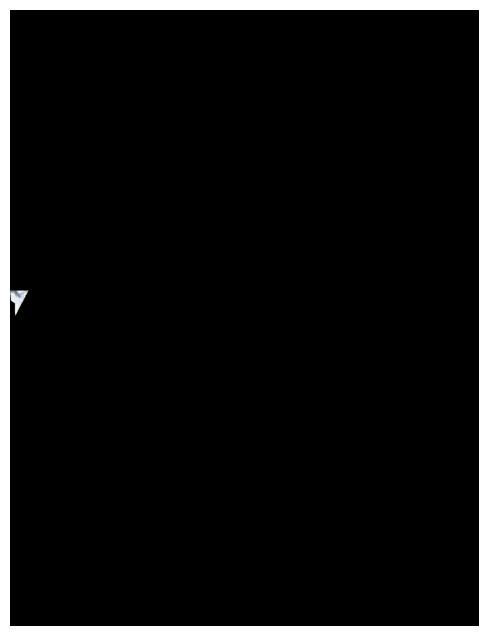

In [11]:
from sklearn.preprocessing import MinMaxScaler
# Function to scale image bands properly
def scale_band(band):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(band)  # Normalize between 0-1

# Assuming red_clipped, green_clipped, and blue_clipped are 2D NumPy arrays
rgb = np.dstack((scale_band(red_clipped.squeeze()),
    scale_band(green_clipped.squeeze()),
    scale_band(blue_clipped.squeeze()),
))

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(rgb)
plt.axis("off")
plt.show()

In [12]:
# def visualize_rgb(red_band, green_band, blue_band, title="RGB Composite"):
#     """
#     Visualizes an RGB composite of raster bands using matplotlib.

#     Parameters:
#     - red_band, green_band, blue_band (numpy array): Red, Green, and Blue bands.
#     - title (str): Title for the plot.
#     """
#     rgb = np.dstack((
#         np.clip(red_band, 0, 1),  # Normalize reflectance between 0-1
#         np.clip(green_band, 0, 1),
#         np.clip(blue_band, 0, 1)
#     ))
#     plt.figure(figsize=(10, 8))
#     plt.imshow(rgb)
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # Example: Visualize RGB composite
# visualize_rgb(red_clipped, green_clipped, blue_clipped, title="Processed RGB Composite")